In [1]:
import io
import os
import time
import tensorflow as tf
tf.config.experimental.set_visible_devices([], "GPU")
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_FLAGS']='--xla_gpu_strict_conv_algorithm_picker=false'
import jax
import jax.numpy as jnp
import numpy as np
from configs.subvp.cifar10_ddpmpp_continuous import get_config
import datasets
import evaluation
import likelihood
import sde_lib
import losses
from models import utils as mutils
import logging
import flax
from typing import Any
from flax.training import checkpoints
# Keep the import below for registering all model definitions
from models import ncsnpp

/home/cyanos/Workspace/OOD_Generative_models/score_flow-main/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = get_config()
config.data.dataset = 'SVHN'
workdir = 'outs/cifar10_subvp_likelihood_tw'
eval_folder="eval"
eval_dir = os.path.join(workdir, eval_folder)
checkpoint_dir = os.path.join(workdir, "checkpoints")
tf.io.gfile.makedirs(eval_dir)
rng = jax.random.PRNGKey(config.seed + 1)

In [4]:
if config.eval.enable_loss or config.eval.enable_bpd:
    # Build data pipeline
    train_ds, eval_ds, _ = datasets.get_dataset(config,
                                                additional_dim=1,
                                                uniform_dequantization=config.data.uniform_dequantization,
                                                evaluation=True)

# Create data normalizer and its inverse
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)

2022-08-11 16:12:35.577791: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...:   0%|          | 0/3 [00:21<?, ? url/s]

In [5]:
# Setup SDEs
if config.training.sde.lower() == 'vpsde':
    sde = sde_lib.VPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
elif config.training.sde.lower() == 'subvpsde':
    sde = sde_lib.subVPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
elif config.training.sde.lower() == 'vesde':
    sde = sde_lib.VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
elif config.training.sde.lower() == 'linearvesde':
    sde = sde_lib.VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales,
                        linear=True)
else:
    raise NotImplementedError(f"SDE {config.training.sde} unknown.")

sampling_eps = config.sampling.smallest_time

In [6]:
# Initialize model
rng, model_rng = jax.random.split(rng)
score_model, init_model_state, initial_params = mutils.init_model(model_rng, config)
optimizer = losses.get_optimizer(config).create(initial_params)
state = mutils.State(step=0, optimizer=optimizer, lr=config.optim.lr,
                    model_state=init_model_state,
                    ema_rate=config.model.ema_rate,
                    params_ema=initial_params,
                    rng=rng)  # pytype: disable=wrong-keyword-args

2022-08-11 15:13:56.180642: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-11 15:13:56.180670: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-11 15:13:58.621579: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2

In [7]:
if config.eval.enable_bpd:
    train_ds_bpd, eval_ds_bpd, _ = datasets.get_dataset(config,
                                                        additional_dim=None,
                                                        uniform_dequantization=True, evaluation=True)
    if config.eval.bpd_dataset.lower() == 'train':
      ds_bpd = train_ds_bpd
      bpd_num_repeats = 1
    elif config.eval.bpd_dataset.lower() == 'test':
      # Go over the dataset 5 times when computing likelihood on the test dataset
      ds_bpd = eval_ds_bpd
      bpd_num_repeats = config.eval.num_repeats
    else:
      raise ValueError(f"No bpd dataset {config.eval.bpd_dataset} recognized.")
    
    # Build the likelihood computation function
    likelihood_fn = likelihood.get_likelihood_fn(sde, score_model, inverse_scaler, eps=config.training.smallest_time)
    

In [8]:
@flax.struct.dataclass
class EvalMeta:
    ckpt_id: int
    sampling_round_id: int
    bpd_round_id: int
    rng: Any

In [9]:
# Add one additional round to get the exact number of samples as required.
num_sampling_rounds = config.eval.num_samples // config.eval.batch_size + 1
if config.eval.enable_bpd:
    num_bpd_rounds = len(ds_bpd) * bpd_num_repeats
else:
    num_bpd_rounds = 1

In [10]:
# Restore evaluation after pre-emption
eval_meta = EvalMeta(ckpt_id=config.eval.begin_ckpt, sampling_round_id=-1, bpd_round_id=-1, rng=rng)
eval_meta = checkpoints.restore_checkpoint(
    eval_dir, eval_meta, step=None, prefix=f"meta_{jax.host_id()}_")

if eval_meta.bpd_round_id < num_bpd_rounds - 1:
    begin_ckpt = eval_meta.ckpt_id
    begin_bpd_round = eval_meta.bpd_round_id + 1
    begin_sampling_round = 0

elif eval_meta.sampling_round_id < num_sampling_rounds - 1:
    begin_ckpt = eval_meta.ckpt_id
    begin_bpd_round = num_bpd_rounds
    begin_sampling_round = eval_meta.sampling_round_id + 1
else:
    begin_ckpt = eval_meta.ckpt_id + 1
    begin_bpd_round = 0
    begin_sampling_round = 0

rng = eval_meta.rng

/home/cyanos/Workspace/OOD_Generative_models/score_flow-main/venv/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py:515: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  warnings.warn(


In [11]:
inceptionv3 = config.data.image_size >= 256
inception_model = evaluation.get_inception_model(inceptionv3=inceptionv3)

In [12]:
print("begin checkpoint: %d" % (begin_ckpt,))
# Wait if the target checkpoint doesn't exist yet
ckpt = config.eval.end_ckpt
ckpt_filename = os.path.join(checkpoint_dir, "checkpoint_{}".format(ckpt))
state = checkpoints.restore_checkpoint(checkpoint_dir, state, step=ckpt)

begin checkpoint: 26


In [13]:
params_ema = state.params_ema.unfreeze()
# params_ema['ResnetBlockBigGANpp_0']['GroupNorm_0']['scale'] = params_ema['ResnetBlockBigGANpp_0']['GroupNorm_0']['scale'].squeeze()
# params_ema['ResnetBlockBigGANpp_0']['GroupNorm_0']['bias'] = params_ema['ResnetBlockBigGANpp_0']['GroupNorm_0']['bias'].squeeze()
cond_tree = jax.tree_map(lambda x: False, params_ema)
def walk_dict(d,depth=0):
    for k,v in sorted(d.items(),key=lambda x: x[0]):
        if isinstance(v, dict):
            # print("  "*depth+ ("%s" % k))
            if 'GroupNorm' in k:
                for sk,sv in v.items():
                    v[sk] = True
            else:
                walk_dict(v,depth+1)
        # else:            
            # print("  "*depth + "%s %s" % (k, v))
walk_dict(cond_tree)
params_ema = jax.tree_map(lambda p, cond: p.squeeze() if cond else p, params_ema, cond_tree)
object.__setattr__(state, 'params_ema', flax.core.frozen_dict.freeze(params_ema))

/tmp/ipykernel_45519/375905512.py:4: FutureWarning: jax.tree_map is deprecated, and will be removed in a future release. Use jax.tree_util.tree_map instead.
  cond_tree = jax.tree_map(lambda x: False, params_ema)
/tmp/ipykernel_45519/375905512.py:17: FutureWarning: jax.tree_map is deprecated, and will be removed in a future release. Use jax.tree_util.tree_map instead.
  params_ema = jax.tree_map(lambda p, cond: p.squeeze() if cond else p, params_ema, cond_tree)


In [14]:
state.params_ema['ResnetBlockBigGANpp_0']['GroupNorm_1']['scale'].shape

(128,)

In [15]:
# Replicate the training state for executing on multiple devices
pstate = flax.jax_utils.replicate(state)

In [16]:
# Compute log-likelihoods (bits/dim) if enabled
if config.eval.enable_bpd:
  bpds = []
  begin_repeat_id = begin_bpd_round // len(ds_bpd)
  begin_batch_id = begin_bpd_round % len(ds_bpd)
  # Repeat multiple times to reduce variance when needed
  for repeat in range(begin_repeat_id, bpd_num_repeats):
    bpd_iter = iter(ds_bpd)  # pytype: disable=wrong-arg-types
    for _ in range(begin_batch_id):
      next(bpd_iter)
    for batch_id in range(begin_batch_id, len(ds_bpd)):
      bpd_round_id = batch_id + len(ds_bpd) * repeat
      if tf.io.gfile.exists(os.path.join(eval_dir,
                                  f"{config.eval.bpd_dataset}_ckpt_{ckpt}_bpd_{bpd_round_id}.npz")):
        continue
      batch = next(bpd_iter)
      eval_batch = jax.tree_map(lambda x: scaler(x._numpy()), batch)
      # if config.eval.dequantizer:
      #   rng, step_rng = jax.random.split(rng)
      #   data = eval_batch['image']
      #   u = jax.random.normal(step_rng, data.shape)
      #   noise, logpd = p_dequantizer(u, inverse_scaler(data))
      #   data = scaler((inverse_scaler(data) * 255. + noise) / 256.)
      #   bpd_d = -logpd / np.log(2.)
      #   dim = np.prod(noise.shape[2:])
      #   bpd_d = bpd_d / dim
      # else:
      data = eval_batch['image']

      rng, *step_rng = jax.random.split(rng, jax.local_device_count() + 1)
      step_rng = jnp.asarray(step_rng)
      bpd = likelihood_fn(step_rng, pstate, data)[0]
      # if config.eval.dequantizer:
      #   bpd = bpd + bpd_d
      bpd = bpd.reshape(-1)
      bpds.extend(bpd)
      logging.info(
        "ckpt: %d, repeat: %d, batch: %d, mean bpd: %6f" % (ckpt, repeat, batch_id, jnp.mean(jnp.asarray(bpds))))
      # Save bits/dim to disk or Google Cloud Storage
      with tf.io.gfile.GFile(os.path.join(eval_dir,
                                          f"{config.eval.bpd_dataset}_ckpt_{ckpt}_bpd_{bpd_round_id}.npz"),
                              "wb") as fout:
        io_buffer = io.BytesIO()
        np.savez_compressed(io_buffer, bpd)
        fout.write(io_buffer.getvalue())

      eval_meta = eval_meta.replace(ckpt_id=ckpt, bpd_round_id=bpd_round_id, rng=rng)
      # Save intermediate states to resume evaluation after pre-emption
      checkpoints.save_checkpoint(
        eval_dir,
        eval_meta,
        step=ckpt * (num_sampling_rounds + num_bpd_rounds) + bpd_round_id,
        keep=1,
        prefix=f"meta_{jax.host_id()}_", overwrite=True)
begin_bpd_round = 0
begin_sampling_round = 0

/tmp/ipykernel_45519/1663449432.py:17: FutureWarning: jax.tree_map is deprecated, and will be removed in a future release. Use jax.tree_util.tree_map instead.
  eval_batch = jax.tree_map(lambda x: scaler(x._numpy()), batch)
/home/cyanos/Workspace/OOD_Generative_models/score_flow-main/venv/lib/python3.10/site-packages/flax/jax_utils.py:61: FutureWarning: jax.tree_map is deprecated, and will be removed in a future release. Use jax.tree_util.tree_map instead.
  return jax.tree_map(lambda x: x[0], tree)
2022-08-11 15:14:17.468108: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-11 15:14:17.716735: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to alloc

KeyboardInterrupt: 

In [ ]:
# Remove all meta files after finishing evaluation
# meta_files = tf.io.gfile.glob(os.path.join(eval_dir, f"meta_{jax.host_id()}_*"))
# for file in meta_files:
#     tf.io.gfile.remove(file)

In [19]:
from glob import glob

In [21]:
bpd_file_paths = glob('outs/cifar10_subvp_likelihood_tw/eval/test_ckpt_26_bpd_*.npz') 
bpd_file_paths = sorted(bpd_file_paths)
bpds = []
for p in bpd_file_paths:
    tmp = np.load(p)
    bpds.append(tmp['arr_0'])
bpds = np.concatenate(bpds)

In [27]:
cifar_nll = bpds
print("CIFAR NLL", np.mean(cifar_nll))

# svhn_nll = compute_nll(test_svhn, model)
# print("SVHN NLL", torch.mean(svhn_nll))

CIFAR NLL 2.9826105


In [29]:
import matplotlib.pyplot as plt

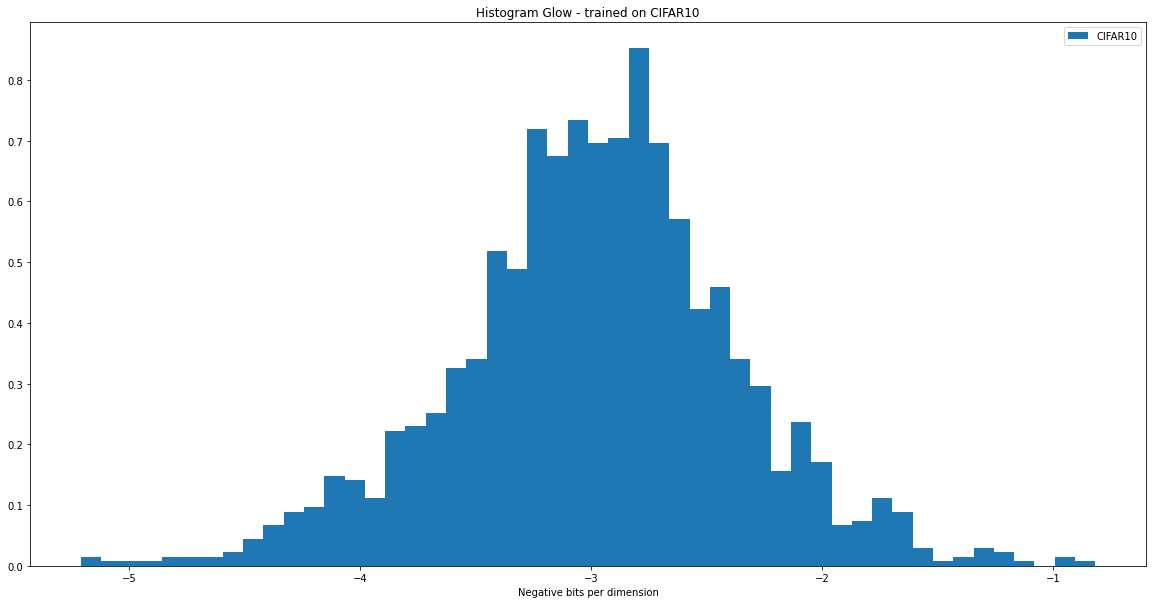

In [31]:
plt.figure(figsize=(20,10))
plt.title("Histogram Glow - trained on CIFAR10")
plt.xlabel("Negative bits per dimension")
# plt.hist(-svhn_nll.numpy(), label="SVHN", density=True, bins=30)
plt.hist(-cifar_nll, label="CIFAR10", density=True, bins=50)
plt.legend()
plt.show()
# plt.savefig("images/histogram_glow_cifar_svhn.png", dpi=300)